# Part I: Basics
As an opening, we first mention some important concepts in deep learning, including
- Artificial Neural Network
- Automatic Differentiation and Backpropogation
- Monte Carlo Estimation 
- Stochastic Gradient Descent.

Given the extensive nature of each subsection, a comprehensive coverage is beyond the scope. Instead, we will pick certain subjects, explain some important ideas and theorems that support these mechanisms, and provide a simple example as demonstration.

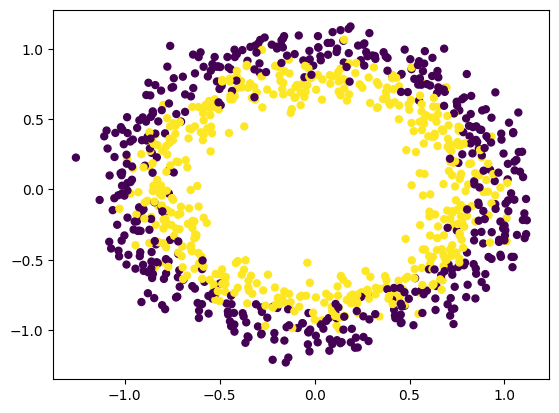

In [1]:
# Standard PyTorch import
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Set seed
SEED = 2024 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Generate dataset
X, y = X, y = make_circles(1000,
                    noise=0.1, 
                    random_state=42)

# Plot dataset
plt.scatter(x=X[:,0],y=X[:,1], marker="o", c=y, s=25)

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(6)

,X1,X2,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1


In [3]:
# Check shape of tensor
X = torch.Tensor(X)
y = torch.Tensor(y)
print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: torch.Size([1000, 2])
y shape: torch.Size([1000])


## Artificial Neural Network

Artificial Neural Network, or abreviated neural network in machine learning context, is the core of deep learning. The name and structure are inspired by human brain, mimicking the interactions of biological neurons. 

Let 
- $x=(x_1,...,x_d)^T\in\mathbb{R}^d$ an input data vector
- $\sigma_i$ the $i$-th activation function such as ReLU, sigmoid or hyperbolic tangent that acts **component-wise** on a vector
- $W_i\in\mathbb{R}^{d_{i_1}\times d_{i_2}}$ the $i$-th weight matrix and $b_i\in\mathbb{R}^{d_{i_2}}$ the $i$-th bias vector. 

Let $A_i$ be the $i$-th affine map from $\mathbb{R}^{d_{{i-1}_2}}\to\mathbb{R}^{d_{{i}_2}}$
$$
A_i y = W_iy+b_i
$$_
where $y_i\in\mathbb{R}^{d_{{i-1}_2}}$ is the output of the $i-1$-th layer.
A neural network of depth $k$ is a series of composition 
$$
\mathcal{N}\mathcal{N}(x) = \sigma_k \circ A_k \circ \cdots \circ \sigma_2 \circ A_2 \circ \sigma_1 \circ A_1 x.
$$


For example, a neural with single layer without activation can be implemented as

In [4]:
# Don't execute
nn.Linear(input_dim,output_dim) 

which performs the linear transformations on $X_{n\times i}\in\mathbb{R}^{n\times i}$:
$$
Y_{n\times o} = X_{n\times i}W_{i\times o}+b_{o}
$$
where $W_{i\times o}$ is a weight matrix and $b_o$ is a bias vector. 

Similarly, we can implement a neural network using three layers with sigmoid for the first and second layer is like

In [5]:
# Don't execute
nn.Sequential(
    nn.Linear(input_dim,hidden_1),
    nn.Sigmoid(),
    nn.Linear(hidden_1,hidden_2),
    nn.Sigmoid(),
    nn.Linear(hidden_2,output_dim)
)

In practice, one can implement the neural network with different tricks: adjusting the depth (number of layers) of neural network or width (number of neurons) of a layer, using dropout [number], using batch normalization [number], or even choosing another activation function if needed.

In [6]:
class Classifier(nn.Module):
    def __init__(self,hidden=4):
        super(Classifier,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2,4),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        output = self.model(x)
        return output

The universal approximation theorem is a key factor contributing to the widespread application of neural networks across various fields and scenarios. The universal approximation theorem originally is given by Cybenko in 1989 [6] using sigmoidal functions
$$
\begin{equation}
\sigma(x)=
\begin{cases}
1, & x\to \infty \\
0, & x\to-\infty
\end{cases}.
\end{equation}
$$
Denote $I_n=[0,1]^n$ the $n$-dimensional unit cube and $C(I_n,\mathbb{R})$ space of continuous functions from $I_n$ to $\mathbb{R}$.

**Theorem (Universal Approximation Theorem, G.Cybenko).** Let $\sigma$ be any continuous sigmoidal function, $f\in C(I_n,\mathbb{R})$. Then finite sums of the form
$$
G^N(x)=\sum_{j=1}^N \alpha_j\sigma(w_j^T x+\theta_j)
$$
are dense in the space of continuous functions $C(I_n,\mathbb{R})$. In other words, given any $f\in C(I_n,\mathbb{R})$, there exists $N\in\mathbb{N}$ such that
$$
|G^N(x)-f(x)|<\epsilon \quad \text{for all } x\in I_n.
$$
This original universal approximation theorem says a neural network with one layer and arbitrary width can approximate any continuous function on $[0,1]^n$, where $N$ is the number of neurons. Now there are many variants and generalizations of the theorem, for example [2],[8]. Another insight of the universality of neural network can be interpreted by ordinary differential equations, as referenced in [7].

## Monte Carlo Estimation
In a nutshell, Monte Carlo estimation simply says that one can replace an intractable integral by an average of summation.

Let $p(\mathbf{x},\boldsymbol{\theta})$ be some probability distribution depending on a collection $\boldsymbol{\theta}$ of parameters. Consider the expectation of the form 
$$
\mathcal{F}(\boldsymbol{\theta})=\int p(\mathbf{x},\boldsymbol{\theta})f(\mathbf{x},\boldsymbol{\phi})d\mathbf{x}=\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[f(\mathbf{x},\boldsymbol{\phi})\right]
$$
where $\mathbf{x}$ is the input of objective $f$ with probability $p(\mathbf{x},\boldsymbol{\theta})$, and $\boldsymbol{\phi}$ is a set of the parameters of $f$. Of course, $\boldsymbol{\phi}$ might be equal to $\boldsymbol{\theta}$. We are interested in learning the parameters $\boldsymbol{\theta}$, which requires the computation of the gradient of $\mathcal{F}(\boldsymbol{\theta})$ with respect to $\theta$:
$$
\nabla_{\boldsymbol{\theta}}\mathcal{F}(\boldsymbol{\theta})=\nabla_{\boldsymbol{\theta}}\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[f(\mathbf{x},\boldsymbol{\phi})\right].
$$
The expectation in general is intractable because the distribution $p(\mathbf{x},\boldsymbol{\theta})$ might be high-dimensional, in deep learning, easily in the order of thousands or even more of dimensions, and very complicated. Moreover, the function $f$ might be non-differentiable, or a black-box function which the output is all we observe, artificial neural network for example. 


The Monte Carlo Method provides another insight of this sort of impossible calculation. Instead of computing the closed form of the integral directly, we draw i.i.d. samples $\hat{\mathbf{x}}^{(1)},...,\hat{\mathbf{x}}^{(S)}$ from $p(\mathbf{x},\boldsymbol{\theta})$, and approximate the integral with the average of $f(\hat{\mathbf{x}}^{(i)},\boldsymbol{\phi})$, called a Monte Carlo estimator:
$$
\bar{\mathcal{F}}_S=\frac{1}{S}\sum_{i=1}^S f(\hat{\mathbf{x}}^{(i)},\boldsymbol{\phi}).
$$
Although $\bar{\mathcal{F}}_S$ is still a random variable because it depends on random variables $\hat{\mathbf{x}}^{(1)},...,\hat{\mathbf{x}}^{(S)}$, now it is equiped with desirable properties:

**Unbiasedness.**
$$
\begin{aligned}
\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[\bar{\mathcal{F}}_S\right] & = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[\frac{1}{S}\sum_{i=1}^S f(\hat{\mathbf{x}}^{(i)},\boldsymbol{\phi})\right] = \frac{1}{S}\sum_{i=1}^S\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[ f(\hat{\mathbf{x}}^{(i)},\boldsymbol{\phi})\right] \\
& = \frac{1}{S}\sum_{i=1}^S\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[f(\mathbf{x},\boldsymbol{\phi})\right] = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[f(\mathbf{x},\boldsymbol{\phi})\right].
\end{aligned}
$$
Unbiasedness is always preferred because it allows us to guarantee the convergence of a stochastic optimisation procedure.

**Consistency.** 
By strong law of large numbers, the random variable $\bar{\mathcal{F}}_S$ converges to $\mathbb{E}_{\mathbf{x}\sim p(\mathbf{x},\boldsymbol{\theta})}\left[f(\mathbf{x},\boldsymbol{\phi})\right]$ almost surely as the number of samples $S$ increases.

Monte Carlo estimation provides a convenient approach to approximate expectations. For example, in generative adversarial networks, the discriminator is updated with the loss function
$$
-\mathbb{E}_{\hat{\mathbf{x}}\sim p_{data}}\left[\log D(\hat{\mathbf{x}})\right]-\mathbb{E}_{\hat{\mathbf{z}}\sim \mathcal{N}(0,\mathbf{I})} \left[\log (1-D(G(\hat{\mathbf{z}})))\right].
$$
where $D$ is the discriminator network, $G$ is the generator network, $x$ is a datapoint sampled from data distribution $p_{data} $ and $z$ is a random noise vector sampled from $\mathcal{N}(0,\mathbf{I})$. With Monte Carlo estimation, instead of calculating two intractable integrals, we only need to calculate the average
$$
-\frac{1}{m}\sum_{i=1}^m \ln D(\hat{\mathbf{x}}^{(i)})-\frac{1}{m}\sum_{i=1}^m \ln(1-D(G(\hat{\mathbf{z}}^{(i)}))).
$$
The quantity $m$, or batch size, is a hyperparameter. 

In our classification task, if the output probability of a datapoint is $\geq 0.5$, it's identified as the class with label "1" otherwise "0". Thus, we use **binary cross entropy** as our loss function, 
$$
-\mathbb{E}_{x_i\sim y_i=1} \log p_i-\mathbb{E}_{x_i\sim y_i=0} \log (1-p_i).
$$
where $p_i=\text{Classifier}(x_i)$. With Monte Carlo estimation, we can implement the loss function
$$
-\left[\frac{1}{m}\sum_{i=1}^{m} y_i\log p_i+(1-y_i)\log(1-p_i)\right]
$$
with full batch $m=256$ in our case.

In [7]:
criterion = nn.BCELoss()

## Automatic Differentiation
Automatic differentiation is widely used for deep learning optimization. It is a clever way of performing chain rule without manually computing derivatives. If you use PyTorch, you don't have to implement autdifferentiation yourself. You can perform autdifferentiation with `autograd` in few lines.

Let $f=f_u\circ f_{u-1}\circ \cdots \circ f_1$ be a function. Each $f_i:\mathbb{R}^n\to\mathbb{R}$ is differentiable. Chain rule of differentiation tells us how to compute the derivative:
$$
\frac{df}{dx} = \frac{df_u}{df_{u-1}}\cdots\frac{df_{2}}{df_{1}}\frac{df_1}{dx}.
$$
**Forward-mode.** Forward-mode autodifferentiation performs the chain rule in the fashion
$$
\frac{df_i}{dx} = \frac{df_i}{df_{i-1}}\frac{df_{i-1}}{dx} \quad \text{for $i=2,...,u$},
$$
or
$$
\begin{equation}
\frac{df}{dx} = \frac{df_u}{df_{u-1}}\left(\cdots\left(\frac{df_3}{df_2}\left(\frac{df_2}{df_1}\frac{df_1}{dx}\right)\right)\right) \tag{F1}.
\end{equation}
$$
**Reverse-mode.** Reverse-mode, also known as backpropagation, performs the chain rule in another way
$$
\frac{df_u}{df_{i-1}} = \frac{df_u}{df_{i}}\frac{df_{i}}{df_{i-1}} \quad \text{for $i=u-1,...,1$ with $f_0=x$},
$$
namely
$$
\begin{equation}
\frac{df}{dx} = \left(\left(\left(\frac{df_u}{df_{u-1}}\frac{df_{u-1}}{df_{u-2}}\right)\frac{df_{u-2}}{df_{u-3}}\right)\cdots\right)\frac{df_1}{dx} \tag{R1}. 
\end{equation}
$$
#### Computational Efficiency
Each evaluation of $\text{(F1)}$ autodifferentiation is a matrix-matrix product, while each calculation of $\text{(R1)}$ is just a vector-matrix product. Thus, the reverse-mode autodifferentiation, or backpropagation, is always preferred for training neural networks.
#### What Autodifferentiation is not
Autodifferentiation is a **procedure of calculating derivatives**; it does not aim to find the closed form of solution. 

**It is not**
- **finite differences**
$$
\frac{\partial}{\partial x_i}f(x_1,...,x_N) \approx \frac{f(x_1,...,x_i+h,...,x_N)-f(x_1,...,x_i,...,x_N)}{h}
$$
which are expensive and induce numerical error. We only use finite differences for testing the gradient. 
- **symbolic differentiation** which can result in complex and redundant expressions.

## (Minibatch) Stochastic Gradient Descent
Nowadays, people usually prefer minibatch stochastic gradient descent to optimize neural networks, as it is more computationally efficient than gradient descent or stochastic gradient descent. 

Let $\ell$ be our loss function. Let $n$ be the number of training datapoint, $b$ the batch size, $\boldsymbol{\theta^0}\in\mathbb{R}^d$ the initial parameter of our neural network and $(\alpha_t)_{t\in\mathbb{N}}$ a sequence of step size, or learning rate. Given a subsest $B\subset \{1,...,n\}$, we define
$$
\nabla_{\boldsymbol{\theta^t}} \ell_B(\boldsymbol{\theta^t})=\frac{1}{|B|}\sum_{i\in B} \nabla_{\boldsymbol{\theta^t}} \ell_i(\boldsymbol{\theta^t})
$$
The minibatch stochastic gradient descent algorithm is given by 
$$
\begin{aligned}
& B_t\subset\{1,...,n\} \quad\quad \text{Sampled uniformly among sets of size $b$} \\
& \boldsymbol{\theta^{t+1}} = \boldsymbol{\theta^t}-\alpha_t \nabla_{\boldsymbol{\theta^t}} \ell_B(\boldsymbol{\theta^t}).
\end{aligned}
$$
Note that $\nabla_{\boldsymbol{\theta^t}} \ell_B(\boldsymbol{\theta^t})$ is an unbiased estimator
$$
\mathbb{E}_{b}\left[\nabla_{\boldsymbol{\theta^t}} \ell_B(\boldsymbol{\theta^t})\right] = \frac{1}{{n \choose b}} \sum_{\substack{B\subset\{1,...,n\} \\ |B|=b}} \nabla_{\boldsymbol{\theta^t}} \ell_B(\boldsymbol{\theta^t}) = \nabla_{\boldsymbol{\theta^t}} \ell(\boldsymbol{\theta^t})
$$
because each batch is sampled with probability $\frac{1}{{n \choose b}}$. Readers interested in the convergence of minibatch SGD with convex and smooth functions may check [3] for related theorems and proofs.


In [10]:
n_epoch = 200
lr = 0.105
model = Classifier()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_record = []
acc_record = []

for i in range(n_epoch):
    model.train()
    
    output_prob = model(X).squeeze()
    pred = (output_prob >= 0.5).float()

    # Calculate loss
    loss = criterion(output_prob, y)
    loss_record.append(loss.item())

    # Calculate accuracy
    correct = (pred == y).sum().item()
    acc = correct / len(pred) * 100
    acc_record.append(acc)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1)%20==0:
        print("Epoch {} loss {:.4f} acc {:.2f}%".format(i+1, loss, acc))

Epoch 20 loss 0.7069 acc 49.40%
Epoch 40 loss 0.7011 acc 48.90%
Epoch 60 loss 0.6982 acc 49.30%
Epoch 80 loss 0.6965 acc 49.80%
Epoch 100 loss 0.6954 acc 49.60%
Epoch 120 loss 0.6948 acc 49.60%
Epoch 140 loss 0.6943 acc 49.60%
Epoch 160 loss 0.6940 acc 50.10%
Epoch 180 loss 0.6938 acc 49.70%
Epoch 200 loss 0.6936 acc 49.50%


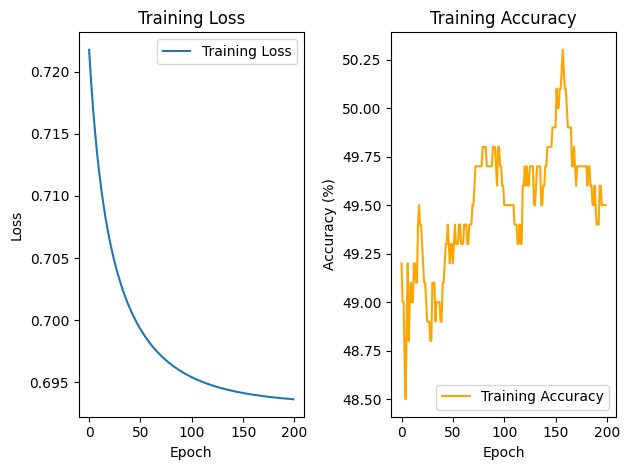

In [11]:
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(loss_record, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_record, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# References
[1] Nitish Srivastava, undefined., et al. "Dropout: A Simple Way to Prevent Neural Networks from Overfitting," in Journal of Machine Learning Research, vol. 15, no. 56, pp. 1929–1958, 2014.

[2] D. Zhou. "Universality of Deep Convolutional Neural Networks.," in CoRR, vol. abs/1805.10769, 2018.

[3] S. Bubeck. "Convex Optimization: Algorithms and Complexity.," in Foundations and Trends in Machine Learning, vol. 8, no. 3-4, pp. 231–357, 2015.

[4] Baydin, A., et al. "Automatic Differentiation in Machine Learning: a Survey.," in J. Mach. Learn. Res., vol. 18, pp. 153:1–153:43, 2017.

[5] Mohamed, S., et al. "Monte Carlo Gradient Estimation in Machine Learning.," in J. Mach. Learn. Res., vol. 21, pp. 132:1–132:62, 2020.

[6] G. Cybenko. "Approximation by superpositions of a sigmoidal function.," in Math. Control. Signals Syst., vol. 2, no. 4, pp. 303–314, 1989.

[7] P. Kidger, "On Neural Differential Equations," 2022.

[8] A. Pinkus. "Approximation theory of the MLP model in neural networks," in Acta Numerica, vol. 8, pp. 143–195, 1999.

[9] S. Ioffe, C. Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift," in Proceedings of the 32nd International Conference on Machine Learning, 2015, pp. 448–456.

[10] S. Ruder, "An overview of gradient descent optimization algorithms," 2016.



